In [1]:
# ==========================
# UMAP
# ==========================
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_openml

# --- Load and subsample data ---
mnist = fetch_openml("mnist_784", as_frame=False)
X, y = mnist.data, mnist.target.astype(int)
random_state = 42

size = 5000
idx = np.random.choice(len(X), size=size, replace=False)
X_sub, y_sub = X[idx], y[idx]

# --- Scale ---
X_scaled = StandardScaler().fit_transform(X_sub)

In [2]:
# --- Hyperparameter grid ---
r = 2
neighbors_list = [5, 10, 15, 25, 50]
min_dist_list = [0.0, 0.1, 0.3, 0.5, 0.8]

results = []

for n_neighbors in neighbors_list:
    for min_dist in min_dist_list:
        try:
            reducer = umap.UMAP(
                n_components=r,
                n_neighbors=n_neighbors,
                min_dist=min_dist,
                random_state=random_state,
                metric='euclidean',
                n_jobs=1
            )
            Z = reducer.fit_transform(X_scaled)

            # --- Split for downstream supervised evaluation ---
            Z_tr, Z_ts, y_tr, y_ts = train_test_split(
                Z, y_sub, test_size=0.2, random_state=random_state, stratify=y_sub
            )

            clf = LogisticRegression(max_iter=1000)
            clf.fit(Z_tr, y_tr)
            acc = accuracy_score(y_ts, clf.predict(Z_ts))
            results.append((r, n_neighbors, min_dist, acc))
            print(f"r={r:>2}, n_neighbors={n_neighbors:>2}, min_dist={min_dist:.1f}, Accuracy={acc:.4f}")

        except Exception as e:
            print(f"r={r:>2}, n_neighbors={n_neighbors:>2}, min_dist={min_dist:.1f} -> skipped ({type(e).__name__})")

# --- Find best ---
best = max(results, key=lambda t: t[3])
print(f"\nBest: r={best[0]}, n_neighbors={best[1]}, min_dist={best[2]}, Accuracy={best[3]:.4f}")

r= 2, n_neighbors= 5, min_dist=0.0, Accuracy=0.7750
r= 2, n_neighbors= 5, min_dist=0.1, Accuracy=0.7540
r= 2, n_neighbors= 5, min_dist=0.3, Accuracy=0.7500
r= 2, n_neighbors= 5, min_dist=0.5, Accuracy=0.7370
r= 2, n_neighbors= 5, min_dist=0.8, Accuracy=0.6890
r= 2, n_neighbors=10, min_dist=0.0, Accuracy=0.7920
r= 2, n_neighbors=10, min_dist=0.1, Accuracy=0.8000
r= 2, n_neighbors=10, min_dist=0.3, Accuracy=0.7730
r= 2, n_neighbors=10, min_dist=0.5, Accuracy=0.7690
r= 2, n_neighbors=10, min_dist=0.8, Accuracy=0.7440
r= 2, n_neighbors=15, min_dist=0.0, Accuracy=0.8170
r= 2, n_neighbors=15, min_dist=0.1, Accuracy=0.7840
r= 2, n_neighbors=15, min_dist=0.3, Accuracy=0.7810
r= 2, n_neighbors=15, min_dist=0.5, Accuracy=0.7580
r= 2, n_neighbors=15, min_dist=0.8, Accuracy=0.7190
r= 2, n_neighbors=25, min_dist=0.0, Accuracy=0.7960
r= 2, n_neighbors=25, min_dist=0.1, Accuracy=0.8020
r= 2, n_neighbors=25, min_dist=0.3, Accuracy=0.8200
r= 2, n_neighbors=25, min_dist=0.5, Accuracy=0.7620
r= 2, n_neig

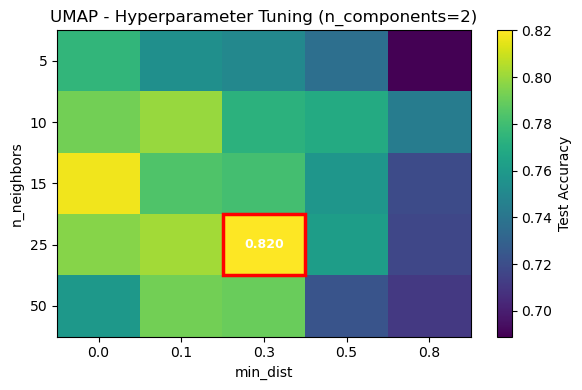

Best performance: n_neighbors=25, min_dist=0.30, Accuracy=0.8200


In [4]:
# --- Heatmap visualization ---
best_r = best[0]
n_vals = sorted(set(neighbors_list))
d_vals = sorted(set(min_dist_list))

acc_matrix = np.zeros((len(n_vals), len(d_vals)))
for r, n, d, acc in results:
    if r == best_r:
        i = n_vals.index(n)
        j = d_vals.index(d)
        acc_matrix[i, j] = acc

best_idx = np.unravel_index(np.argmax(acc_matrix), acc_matrix.shape)
best_n_idx, best_d_idx = best_idx
best_acc = acc_matrix[best_n_idx, best_d_idx]
best_n, best_d = n_vals[best_n_idx], d_vals[best_d_idx]

plt.figure(figsize=(6,4))
plt.imshow(acc_matrix, cmap='viridis', aspect='auto')
plt.colorbar(label="Test Accuracy")
plt.xticks(range(len(d_vals)), [f"{d:.1f}" for d in d_vals])
plt.yticks(range(len(n_vals)), n_vals)
plt.xlabel("min_dist")
plt.ylabel("n_neighbors")
plt.title(f"UMAP - Hyperparameter Tuning (n_components={best_r})")

ax = plt.gca()
rect = Rectangle(
    (best_d_idx - 0.5, best_n_idx - 0.5),
    1, 1,
    linewidth=2.5,
    edgecolor='red',
    facecolor='none'
)
ax.add_patch(rect)
plt.text(best_d_idx, best_n_idx, f"{best_acc:.3f}",
         color='white', fontsize=9, ha='center', va='center', fontweight='bold')

plt.tight_layout()
plt.savefig("docs/umap_hyperparam_heatmap.png", dpi=150)
plt.show()

print(f"Best performance: n_neighbors={best_n}, min_dist={best_d:.2f}, Accuracy={best_acc:.4f}")

/opt/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


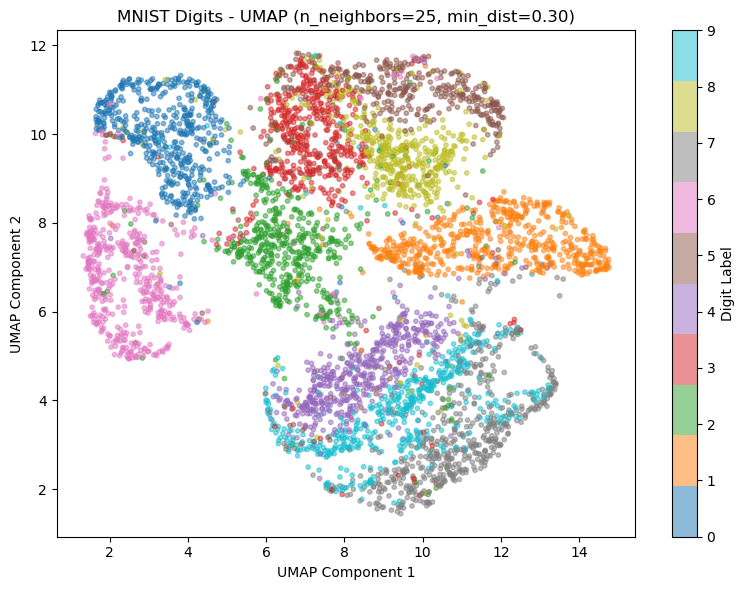

In [5]:
# --- 2D visualization using best parameters ---
reducer2 = umap.UMAP(
    n_components=2,
    n_neighbors=best_n,
    min_dist=best_d,
    random_state=random_state,
    metric='euclidean'
)
Z2 = reducer2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
sc = plt.scatter(Z2[:,0], Z2[:,1], c=y_sub, cmap="tab10", s=10, alpha=0.5)
plt.colorbar(sc, label="Digit Label")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.title(f"MNIST Digits - UMAP (n_neighbors={best_n}, min_dist={best_d:.2f})")
plt.tight_layout()
plt.savefig("docs/umap12_labeled_2d_tuned.png", dpi=150)
plt.show()
